In [1]:
import pandas as pd
import numpy as np
import scipy.sparse
import pathlib
import hetmatpy.matrix

# Set up paths
repo_dir = pathlib.Path('../').resolve()
data_dir = repo_dir / 'data'
permutations_dir = data_dir / 'permutations'

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")

# List available permutations
available_permutations = sorted([p.name for p in permutations_dir.iterdir() if p.is_dir()])
print(f"Available permutations: {available_permutations}")

Repository directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn
Data directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data
Permutations directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations
Available permutations: ['000.hetmat', '000.hetmat.bak', '001.hetmat']


In [2]:
def load_permutation_data(permutation_name):
    """
    Load AeG edges, Anatomy nodes, and Gene nodes for a specific permutation.
    
    Parameters:
    -----------
    permutation_name : str
        Name of the permutation directory (e.g., '001.hetmat')
    
    Returns:
    --------
    dict : Dictionary containing loaded data with keys:
           - 'aeg_edges': scipy sparse matrix for AeG edges
           - 'anatomy_nodes': pandas DataFrame of anatomy nodes
           - 'gene_nodes': pandas DataFrame of gene nodes
           - 'permutation_path': pathlib.Path to the permutation directory
    """
    # Set up paths for this permutation
    perm_dir = permutations_dir / permutation_name
    edges_dir = perm_dir / 'edges'
    nodes_dir = perm_dir / 'nodes'
    
    if not perm_dir.exists():
        raise FileNotFoundError(f"Permutation directory not found: {perm_dir}")
    
    print(f"Loading data from permutation: {permutation_name}")
    print(f"Permutation path: {perm_dir}")
    
    # Load AeG edges (Anatomy-expresses-Gene)
    aeg_path = edges_dir / 'AeG.sparse.npz'
    if not aeg_path.exists():
        raise FileNotFoundError(f"AeG edges file not found: {aeg_path}")
    
    aeg_edges = scipy.sparse.load_npz(aeg_path)
    print(f"Loaded AeG edges: {aeg_edges.shape} matrix with {aeg_edges.nnz} non-zero entries")
    
    # Load Anatomy nodes
    anatomy_path = nodes_dir / 'Anatomy.tsv'
    if not anatomy_path.exists():
        raise FileNotFoundError(f"Anatomy nodes file not found: {anatomy_path}")
    
    anatomy_nodes = pd.read_csv(anatomy_path, sep='\t')
    print(f"Loaded Anatomy nodes: {len(anatomy_nodes)} nodes")
    print(f"Anatomy columns: {list(anatomy_nodes.columns)}")
    
    # Load Gene nodes
    gene_path = nodes_dir / 'Gene.tsv'
    if not gene_path.exists():
        raise FileNotFoundError(f"Gene nodes file not found: {gene_path}")
    
    gene_nodes = pd.read_csv(gene_path, sep='\t')
    print(f"Loaded Gene nodes: {len(gene_nodes)} nodes")
    print(f"Gene columns: {list(gene_nodes.columns)}")
    
    return {
        'aeg_edges': aeg_edges,
        'anatomy_nodes': anatomy_nodes,
        'gene_nodes': gene_nodes,
        'permutation_path': perm_dir
    }

In [3]:
# Load data from the first available permutation
if available_permutations:
    # Use the first permutation as an example
    example_permutation = available_permutations[0]
    print(f"Loading example data from: {example_permutation}")
    
    # Load the data
    perm_data = load_permutation_data(example_permutation)
    
    # Access the loaded data
    aeg_edges = perm_data['aeg_edges']
    anatomy_nodes = perm_data['anatomy_nodes']
    gene_nodes = perm_data['gene_nodes']
    
    print("\n" + "="*50)
    print("DATA SUMMARY")
    print("="*50)
    print(f"AeG edges matrix shape: {aeg_edges.shape}")
    print(f"AeG edges density: {aeg_edges.nnz / (aeg_edges.shape[0] * aeg_edges.shape[1]):.6f}")
    print(f"Number of Anatomy nodes: {len(anatomy_nodes)}")
    print(f"Number of Gene nodes: {len(gene_nodes)}")
    
    # Show sample data
    print("\nSample Anatomy nodes:")
    print(anatomy_nodes.head())
    
    print("\nSample Gene nodes:")
    print(gene_nodes.head())
    
else:
    print("No permutations found in the permutations directory!")

Loading example data from: 000.hetmat
Loading data from permutation: 000.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']

DATA SUMMARY
AeG edges matrix shape: (402, 20945)
AeG edges density: 0.062519
Number of Anatomy nodes: 402
Number of Gene nodes: 20945

Sample Anatomy nodes:
   position      identifier                       name
0         0  UBERON:0000002             uterine cervix
1         1  UBERON:0000004                       nose
2         2  UBERON:0000006        islet of Langerhans
3         3  UBERON:0000007            pituitary gland
4         4  UBERON:0000010  peripheral nervous system

Sample Gene nodes:
   position  identifier      name
0

In [6]:
def load_all_permutations():
    """
    Load AeG edges, Anatomy nodes, and Gene nodes from all available permutations.
    
    Returns:
    --------
    dict : Dictionary with permutation names as keys and loaded data as values
    """
    all_permutations = {}
    
    for perm_name in available_permutations:
        try:
            print(f"\nLoading permutation: {perm_name}")
            perm_data = load_permutation_data(perm_name)
            all_permutations[perm_name] = perm_data
            print(f"✓ Successfully loaded {perm_name}")
        except Exception as e:
            print(f"✗ Failed to load {perm_name}: {e}")
    
    return all_permutations

# Uncomment the following lines to load all permutations
print("Loading all available permutations...")
all_perm_data = load_all_permutations()
print(f"\nSuccessfully loaded {len(all_perm_data)} permutations: {list(all_perm_data.keys())}")

Loading all available permutations...

Loading permutation: 000.hetmat
Loading data from permutation: 000.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']
✓ Successfully loaded 000.hetmat

Loading permutation: 000.hetmat.bak
Loading data from permutation: 000.hetmat.bak
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat.bak
✗ Failed to load 000.hetmat.bak: AeG edges file not found: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat.bak/edges/AeG.sparse.npz

Loading permutation: 001.hetmat
Lo

In [7]:
# Neural Network and Machine Learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("Neural network libraries imported successfully!")

Neural network libraries imported successfully!


In [8]:
def prepare_edge_prediction_data(permutation_data, sample_negative_ratio=1.0):
    """
    Prepare training data for edge prediction based on source and target degrees.
    
    Parameters:
    -----------
    permutation_data : dict
        Dictionary containing permutation data with AeG edges, anatomy nodes, and gene nodes
    sample_negative_ratio : float
        Ratio of negative samples to positive samples (1.0 means equal number)
    
    Returns:
    --------
    tuple : (features, labels) where features are [source_degree, target_degree] 
            and labels are binary edge existence indicators
    """
    aeg_edges = permutation_data['aeg_edges']
    anatomy_nodes = permutation_data['anatomy_nodes']
    gene_nodes = permutation_data['gene_nodes']
    
    # Calculate degrees
    anatomy_degrees = np.array(aeg_edges.sum(axis=1)).flatten()  # Row sums (anatomy -> gene connections)
    gene_degrees = np.array(aeg_edges.sum(axis=0)).flatten()     # Column sums (gene <- anatomy connections)
    
    print(f"Anatomy degree range: {anatomy_degrees.min()} - {anatomy_degrees.max()}")
    print(f"Gene degree range: {gene_degrees.min()} - {gene_degrees.max()}")
    
    # Get positive examples (existing edges)
    positive_rows, positive_cols = aeg_edges.nonzero()
    positive_features = np.column_stack([
        anatomy_degrees[positive_rows],  # Source degrees (anatomy)
        gene_degrees[positive_cols]      # Target degrees (genes)
    ])
    positive_labels = np.ones(len(positive_rows))
    
    print(f"Number of positive examples (existing edges): {len(positive_labels)}")
    
    # Generate negative examples (non-existing edges)
    n_negative = int(len(positive_labels) * sample_negative_ratio)
    
    # Sample random anatomy-gene pairs that don't have edges
    negative_features = []
    negative_labels = []
    
    attempts = 0
    max_attempts = n_negative * 10  # Prevent infinite loop
    
    while len(negative_features) < n_negative and attempts < max_attempts:
        # Sample random anatomy and gene indices
        anatomy_idx = np.random.randint(0, len(anatomy_nodes))
        gene_idx = np.random.randint(0, len(gene_nodes))
        
        # Check if this pair doesn't have an edge
        if aeg_edges[anatomy_idx, gene_idx] == 0:
            negative_features.append([anatomy_degrees[anatomy_idx], gene_degrees[gene_idx]])
            negative_labels.append(0)
        
        attempts += 1
    
    negative_features = np.array(negative_features)
    negative_labels = np.array(negative_labels)
    
    print(f"Number of negative examples (non-existing edges): {len(negative_labels)}")
    
    # Combine positive and negative examples
    all_features = np.vstack([positive_features, negative_features])
    all_labels = np.concatenate([positive_labels, negative_labels])
    
    # Shuffle the data
    shuffle_idx = np.random.permutation(len(all_labels))
    all_features = all_features[shuffle_idx]
    all_labels = all_labels[shuffle_idx]
    
    return all_features, all_labels

In [9]:
class EdgePredictionNN(nn.Module):
    """
    Neural Network for predicting edge probability based on source and target degrees.
    """
    
    def __init__(self, input_dim=2, hidden_dims=[64, 32, 16], dropout_rate=0.2):
        super(EdgePredictionNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer with sigmoid activation for probability
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

# Function to train the model
def train_edge_prediction_model(features, labels, test_size=0.2, epochs=100, batch_size=1024, learning_rate=0.001):
    """
    Train the edge prediction neural network.
    
    Parameters:
    -----------
    features : numpy.ndarray
        Feature matrix with source and target degrees
    labels : numpy.ndarray
        Binary labels for edge existence
    test_size : float
        Proportion of data for testing
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
    learning_rate : float
        Learning rate for optimizer
    
    Returns:
    --------
    tuple : (model, train_history, test_metrics)
    """
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = EdgePredictionNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training history
    train_losses = []
    val_losses = []
    val_aucs = []
    
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
    print(f"Feature shapes: {X_train.shape}, Labels shape: {y_train.shape}")
    
    # Training loop
    model.train()
    for epoch in tqdm(range(epochs), desc="Training"):
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_predictions = []
        val_true = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                val_predictions.extend(outputs.cpu().numpy())
                val_true.extend(batch_y.cpu().numpy())
        
        # Calculate metrics
        val_auc = roc_auc_score(val_true, val_predictions)
        
        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        val_aucs.append(val_auc)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val AUC: {val_auc:.4f}")
        
        model.train()
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor).cpu().numpy()
    
    test_auc = roc_auc_score(y_test, test_predictions)
    test_ap = average_precision_score(y_test, test_predictions)
    
    train_history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_aucs': val_aucs
    }
    
    test_metrics = {
        'auc': test_auc,
        'average_precision': test_ap,
        'predictions': test_predictions,
        'true_labels': y_test,
        'scaler': scaler
    }
    
    return model, train_history, test_metrics

print("Neural network architecture and training function defined!")

Neural network architecture and training function defined!


In [10]:
def plot_training_history(train_history):
    """Plot training history including loss curves and validation AUC."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Loss curves
    axes[0].plot(train_history['train_losses'], label='Training Loss')
    axes[0].plot(train_history['val_losses'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Validation AUC
    axes[1].plot(train_history['val_aucs'], label='Validation AUC', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('AUC')
    axes[1].set_title('Validation AUC Over Time')
    axes[1].legend()
    axes[1].grid(True)
    
    # Final validation metrics
    final_auc = train_history['val_aucs'][-1]
    axes[2].bar(['Final Val AUC'], [final_auc], color='green', alpha=0.7)
    axes[2].set_ylabel('AUC Score')
    axes[2].set_title('Final Validation Performance')
    axes[2].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(test_metrics):
    """Evaluate and visualize model performance."""
    predictions = test_metrics['predictions']
    true_labels = test_metrics['true_labels']
    auc = test_metrics['auc']
    ap = test_metrics['average_precision']
    
    print(f"Test AUC: {auc:.4f}")
    print(f"Average Precision: {ap:.4f}")
    
    # Create evaluation plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    axes[0, 1].plot(recall, precision, label=f'PR Curve (AP = {ap:.3f})')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Prediction distribution
    axes[1, 0].hist(predictions[true_labels == 0], bins=50, alpha=0.7, label='Negative', density=True)
    axes[1, 0].hist(predictions[true_labels == 1], bins=50, alpha=0.7, label='Positive', density=True)
    axes[1, 0].set_xlabel('Predicted Probability')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Prediction Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Confusion matrix at different thresholds
    thresholds = [0.3, 0.5, 0.7]
    threshold_results = []
    
    for thresh in thresholds:
        pred_binary = (predictions >= thresh).astype(int)
        from sklearn.metrics import confusion_matrix, classification_report
        cm = confusion_matrix(true_labels, pred_binary)
        tn, fp, fn, tp = cm.ravel()
        
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
        
        threshold_results.append({
            'threshold': thresh,
            'precision': precision_val,
            'recall': recall_val,
            'f1': f1_val
        })
    
    # Plot threshold performance
    thresh_df = pd.DataFrame(threshold_results)
    x_pos = range(len(thresholds))
    width = 0.25
    
    axes[1, 1].bar([x - width for x in x_pos], thresh_df['precision'], width, label='Precision', alpha=0.8)
    axes[1, 1].bar(x_pos, thresh_df['recall'], width, label='Recall', alpha=0.8)
    axes[1, 1].bar([x + width for x in x_pos], thresh_df['f1'], width, label='F1-Score', alpha=0.8)
    
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Performance at Different Thresholds')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([f'{t:.1f}' for t in thresholds])
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return threshold_results

print("Evaluation and visualization functions defined!")

Evaluation and visualization functions defined!


In [ ]:
# Train the neural network on a single permutation
print("="*60)
print("TRAINING EDGE PREDICTION NEURAL NETWORK")
print("="*60)

# Use the first permutation for training
training_permutation = list(all_perm_data.keys())[0]
print(f"Training on permutation: {training_permutation}")

# Prepare training data
print("\nPreparing training data...")
features, labels = prepare_edge_prediction_data(
    all_perm_data[training_permutation], 
    sample_negative_ratio=1.0
)

print(f"Feature matrix shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Positive examples: {np.sum(labels == 1)}")
print(f"Negative examples: {np.sum(labels == 0)}")

# Train the model
print("\nTraining neural network...")
model, train_history, test_metrics = train_edge_prediction_model(
    features, labels, 
    epochs=100,
    batch_size=512,
    learning_rate=0.001
)

print(f"\nTraining completed!")
print(f"Final Test AUC: {test_metrics['auc']:.4f}")
print(f"Final Test Average Precision: {test_metrics['average_precision']:.4f}")

TRAINING EDGE PREDICTION NEURAL NETWORK
Training on permutation: 000.hetmat

Preparing training data...
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
Feature matrix shape: (1052814, 2)
Labels shape: (1052814,)
Positive examples: 526407
Negative examples: 526407

Training neural network...
Number of negative examples (non-existing edges): 526407
Feature matrix shape: (1052814, 2)
Labels shape: (1052814,)
Positive examples: 526407
Negative examples: 526407

Training neural network...
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training:  20%|██        | 20/100 [01:41<06:45,  5.07s/it]

Epoch 20/100: Train Loss: 0.1333, Val Loss: 0.1312, Val AUC: 0.9876


Training:  40%|████      | 40/100 [03:20<04:48,  4.82s/it]

Epoch 40/100: Train Loss: 0.1326, Val Loss: 0.1276, Val AUC: 0.9876


Training:  60%|██████    | 60/100 [04:59<03:20,  5.02s/it]

Epoch 60/100: Train Loss: 0.1330, Val Loss: 0.1279, Val AUC: 0.9877


Training:  80%|████████  | 80/100 [06:39<01:38,  4.93s/it]

Epoch 80/100: Train Loss: 0.1323, Val Loss: 0.1280, Val AUC: 0.9876


Training: 100%|██████████| 100/100 [08:17<00:00,  4.98s/it]

Epoch 100/100: Train Loss: 0.1366, Val Loss: 0.1280, Val AUC: 0.9876

Training completed!
Final Test AUC: 0.9876
Final Test Average Precision: 0.9849


Plotting training history...


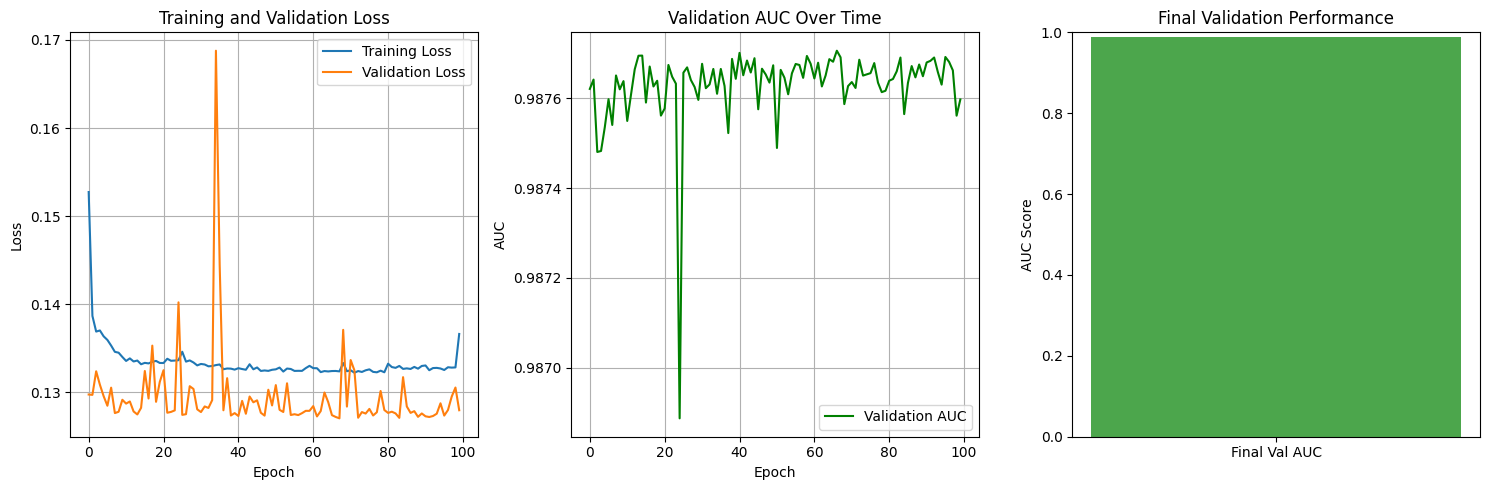


Evaluating model performance...
Test AUC: 0.9876
Average Precision: 0.9849


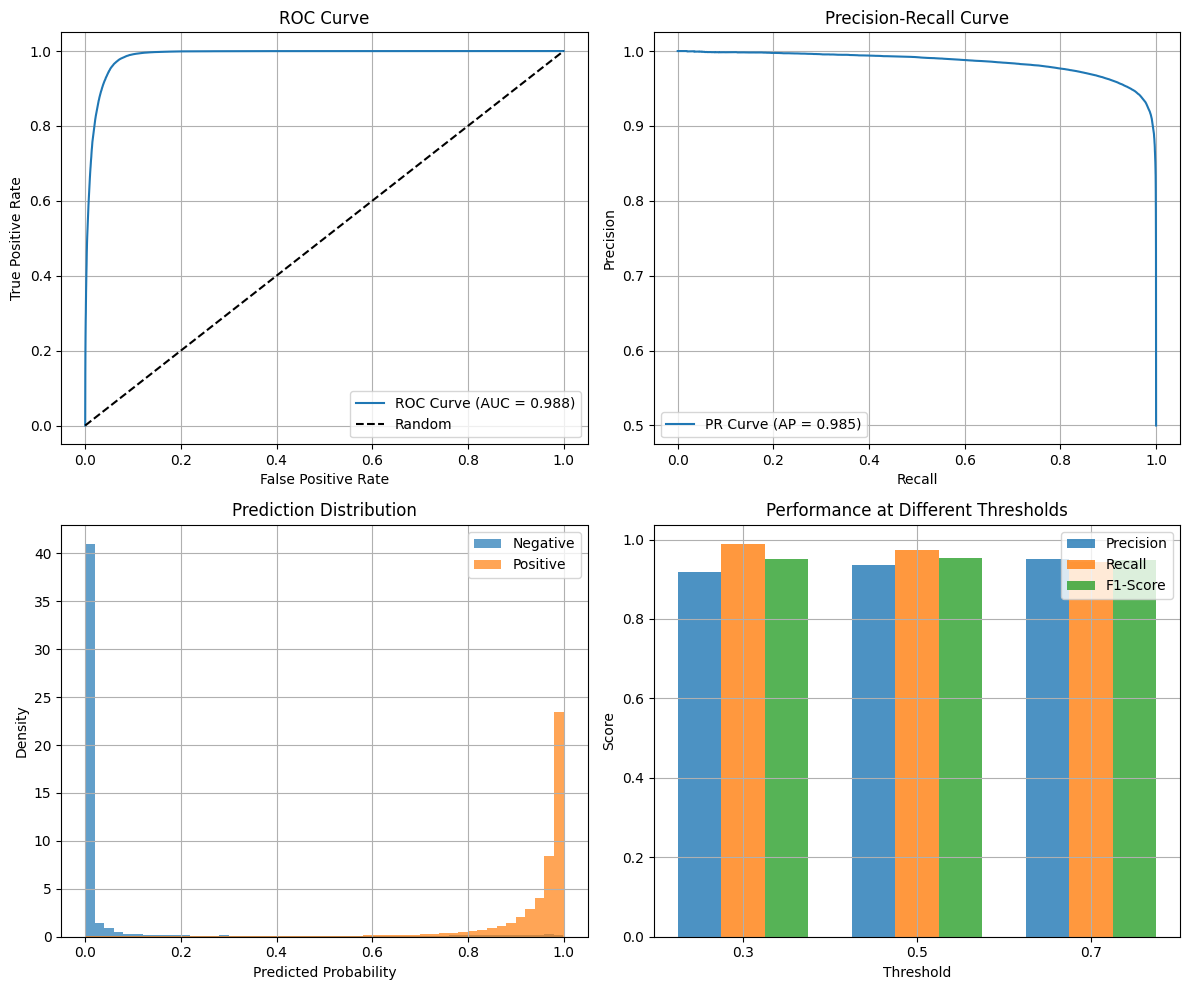

In [12]:
# Visualize training results
print("Plotting training history...")
plot_training_history(train_history)

print("\nEvaluating model performance...")
threshold_results = evaluate_model_performance(test_metrics)

CREATING EDGE PROBABILITY HEATMAP
Source degree range: 1 - 15036
Target degree range: 1 - 98


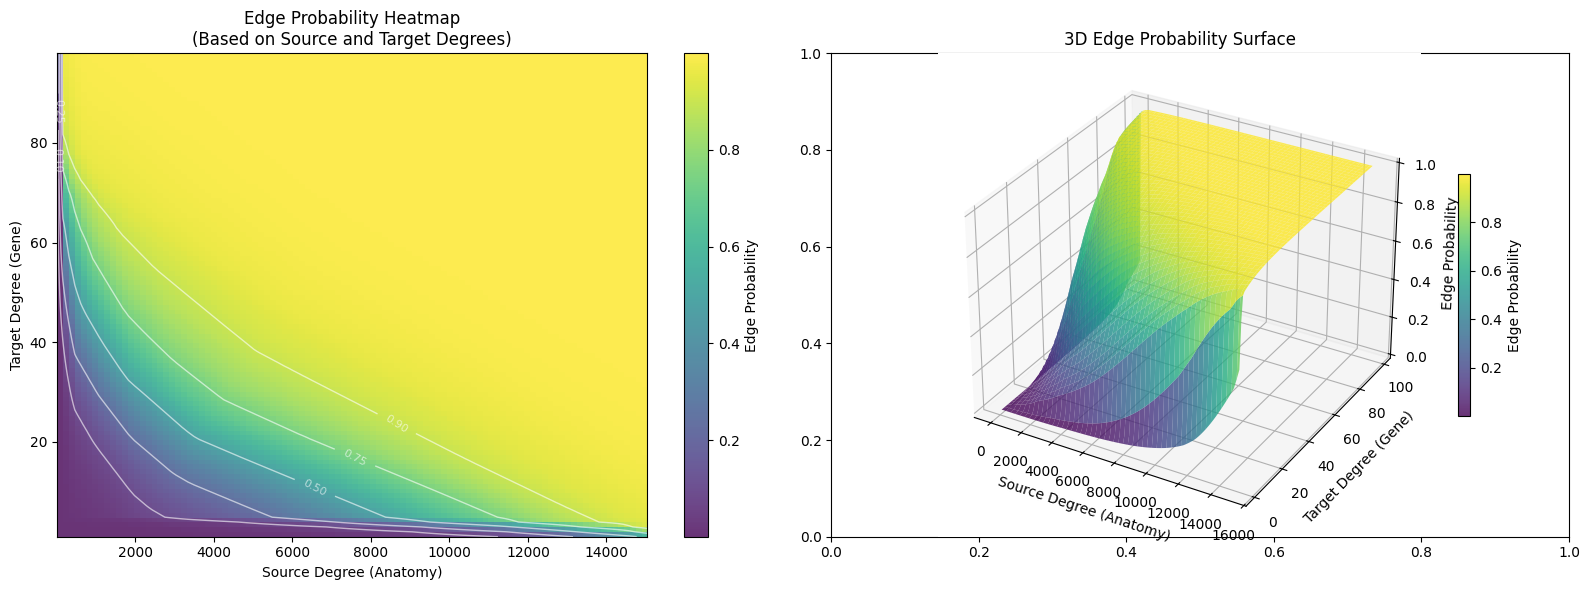

Heatmap created with resolution: (100, 100)
Probability range: 0.0000 - 1.0000
Mean probability: 0.8315
Standard deviation: 0.2823


In [13]:
def create_edge_probability_heatmap(model, scaler, degree_ranges=None, resolution=50):
    """
    Create a heatmap showing edge probability based on source and target degrees.
    
    Parameters:
    -----------
    model : EdgePredictionNN
        Trained neural network model
    scaler : StandardScaler
        Fitted scaler for feature normalization
    degree_ranges : tuple or None
        (min_degree, max_degree) for both source and target. If None, uses data ranges
    resolution : int
        Number of grid points along each axis
    
    Returns:
    --------
    tuple : (probability_matrix, source_degrees, target_degrees)
    """
    
    # Determine degree ranges from the training data if not provided
    if degree_ranges is None:
        # Get degree ranges from the current permutation data
        anatomy_degrees = np.array(aeg_edges.sum(axis=1)).flatten()
        gene_degrees = np.array(aeg_edges.sum(axis=0)).flatten()
        
        min_source = max(1, anatomy_degrees.min())  # Avoid zero degrees
        max_source = anatomy_degrees.max()
        min_target = max(1, gene_degrees.min())
        max_target = gene_degrees.max()
    else:
        min_source, max_source = degree_ranges
        min_target, max_target = degree_ranges
    
    print(f"Source degree range: {min_source} - {max_source}")
    print(f"Target degree range: {min_target} - {max_target}")
    
    # Create degree grids
    source_degrees = np.linspace(min_source, max_source, resolution)
    target_degrees = np.linspace(min_target, max_target, resolution)
    
    # Create meshgrid for all combinations
    source_grid, target_grid = np.meshgrid(source_degrees, target_degrees)
    
    # Flatten grids to create feature matrix
    features_grid = np.column_stack([
        source_grid.flatten(),
        target_grid.flatten()
    ])
    
    # Scale features using the same scaler from training
    features_scaled = scaler.transform(features_grid)
    
    # Convert to PyTorch tensor
    features_tensor = torch.FloatTensor(features_scaled)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        probabilities = model(features_tensor).cpu().numpy()
    
    # Reshape back to grid
    probability_matrix = probabilities.reshape(resolution, resolution)
    
    return probability_matrix, source_degrees, target_degrees

# Create the heatmap
print("="*60)
print("CREATING EDGE PROBABILITY HEATMAP")
print("="*60)

# Create probability heatmap
probability_matrix, source_degrees, target_degrees = create_edge_probability_heatmap(
    model, test_metrics['scaler'], resolution=100
)

# Create the visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Main heatmap
im1 = axes[0].imshow(probability_matrix, 
                     extent=[source_degrees.min(), source_degrees.max(), 
                            target_degrees.min(), target_degrees.max()],
                     origin='lower', aspect='auto', cmap='viridis', alpha=0.8)

axes[0].set_xlabel('Source Degree (Anatomy)')
axes[0].set_ylabel('Target Degree (Gene)')
axes[0].set_title('Edge Probability Heatmap\n(Based on Source and Target Degrees)')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Edge Probability')

# Add contour lines
contour_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
contours = axes[0].contour(source_degrees, target_degrees, probability_matrix, 
                          levels=contour_levels, colors='white', alpha=0.6, linewidths=1)
axes[0].clabel(contours, inline=True, fontsize=8, fmt='%.2f')

# Second plot: 3D surface (alternative view)
from mpl_toolkits.mplot3d import Axes3D

# Create 3D subplot
ax_3d = fig.add_subplot(122, projection='3d')
source_mesh, target_mesh = np.meshgrid(source_degrees, target_degrees)

surface = ax_3d.plot_surface(source_mesh, target_mesh, probability_matrix,
                            cmap='viridis', alpha=0.8, edgecolor='none')

ax_3d.set_xlabel('Source Degree (Anatomy)')
ax_3d.set_ylabel('Target Degree (Gene)')
ax_3d.set_zlabel('Edge Probability')
ax_3d.set_title('3D Edge Probability Surface')

# Add colorbar for 3D plot
cbar2 = plt.colorbar(surface, ax=ax_3d, shrink=0.5)
cbar2.set_label('Edge Probability')

plt.tight_layout()
plt.show()

print(f"Heatmap created with resolution: {probability_matrix.shape}")
print(f"Probability range: {probability_matrix.min():.4f} - {probability_matrix.max():.4f}")
print(f"Mean probability: {probability_matrix.mean():.4f}")
print(f"Standard deviation: {probability_matrix.std():.4f}")

In [ ]:
# Additional analysis: Probability patterns across degree ranges
print("\n" + "="*60)
print("DETAILED PROBABILITY ANALYSIS")
print("="*60)

# Create more detailed analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Probability distribution histogram
axes[0, 0].hist(probability_matrix.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Edge Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Edge Probabilities')
axes[0, 0].grid(True, alpha=0.3)

# Add summary statistics
mean_prob = probability_matrix.mean()
median_prob = np.median(probability_matrix)
axes[0, 0].axvline(mean_prob, color='red', linestyle='--', label=f'Mean: {mean_prob:.3f}')
axes[0, 0].axvline(median_prob, color='orange', linestyle='--', label=f'Median: {median_prob:.3f}')
axes[0, 0].legend()

# 2. Probability vs Source Degree (averaged over target degrees)
mean_prob_by_source = probability_matrix.mean(axis=0)  # Average over target degrees
axes[0, 1].plot(source_degrees, mean_prob_by_source, 'b-', linewidth=2, label='Mean Probability')
axes[0, 1].fill_between(source_degrees, 
                       probability_matrix.min(axis=0), 
                       probability_matrix.max(axis=0), 
                       alpha=0.3, label='Min-Max Range')
axes[0, 1].set_xlabel('Source Degree (Anatomy)')
axes[0, 1].set_ylabel('Edge Probability')
axes[0, 1].set_title('Edge Probability vs Source Degree')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Probability vs Target Degree (averaged over source degrees)
mean_prob_by_target = probability_matrix.mean(axis=1)  # Average over source degrees
axes[1, 0].plot(target_degrees, mean_prob_by_target, 'g-', linewidth=2, label='Mean Probability')
axes[1, 0].fill_between(target_degrees, 
                       probability_matrix.min(axis=1), 
                       probability_matrix.max(axis=1), 
                       alpha=0.3, label='Min-Max Range')
axes[1, 0].set_xlabel('Target Degree (Gene)')
axes[1, 0].set_ylabel('Edge Probability')
axes[1, 0].set_title('Edge Probability vs Target Degree')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Difference from diagonal (source degree = target degree)
# Create a heatmap showing how probability differs from the diagonal
diagonal_prob = np.diag(probability_matrix)
source_mesh, target_mesh = np.meshgrid(source_degrees, target_degrees)

# Calculate difference from diagonal expectation
diagonal_interp = np.interp(target_mesh, source_degrees, diagonal_prob)
prob_diff = probability_matrix - diagonal_interp

im = axes[1, 1].imshow(prob_diff, 
                      extent=[source_degrees.min(), source_degrees.max(), 
                             target_degrees.min(), target_degrees.max()],
                      origin='lower', aspect='auto', cmap='RdBu_r', alpha=0.8)

axes[1, 1].set_xlabel('Source Degree (Anatomy)')
axes[1, 1].set_ylabel('Target Degree (Gene)')
axes[1, 1].set_title('Probability Difference from Diagonal')

# Add diagonal line
axes[1, 1].plot([source_degrees.min(), source_degrees.max()], 
               [target_degrees.min(), target_degrees.max()], 
               'k--', linewidth=2, alpha=0.7, label='Diagonal')
axes[1, 1].legend()

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Probability Difference')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Overall probability range: {probability_matrix.min():.4f} - {probability_matrix.max():.4f}")
print(f"Mean probability: {probability_matrix.mean():.4f} ± {probability_matrix.std():.4f}")
print(f"Median probability: {np.median(probability_matrix):.4f}")

# Find high and low probability regions
high_prob_threshold = np.percentile(probability_matrix, 90)
low_prob_threshold = np.percentile(probability_matrix, 10)

print(f"\nHigh probability regions (>90th percentile, >{high_prob_threshold:.3f}):")
high_prob_mask = probability_matrix > high_prob_threshold
high_prob_indices = np.where(high_prob_mask)
if len(high_prob_indices[0]) > 0:
    for i in range(min(5, len(high_prob_indices[0]))):  # Show first 5
        source_idx, target_idx = high_prob_indices[1][i], high_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")

print(f"\nLow probability regions (<10th percentile, <{low_prob_threshold:.3f}):")
low_prob_mask = probability_matrix < low_prob_threshold
low_prob_indices = np.where(low_prob_mask)
if len(low_prob_indices[0]) > 0:
    for i in range(min(5, len(low_prob_indices[0]))):  # Show first 5
        source_idx, target_idx = low_prob_indices[1][i], low_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")

In [14]:
def train_across_permutations(all_permutation_data, epochs=20):
    """
    Train models across all permutations and compare performance.
    
    Parameters:
    -----------
    all_permutation_data : dict
        Dictionary containing all permutation data
    epochs : int
        Number of epochs for training each model
    
    Returns:
    --------
    dict : Results for each permutation
    """
    results = {}
    
    print("="*60)
    print("TRAINING ACROSS ALL PERMUTATIONS")
    print("="*60)
    
    for perm_name, perm_data in all_permutation_data.items():
        print(f"\nTraining on permutation: {perm_name}")
        print("-" * 40)
        
        try:
            # Prepare data
            features, labels = prepare_edge_prediction_data(perm_data, sample_negative_ratio=1.0)
            
            # Train model
            model, train_history, test_metrics = train_edge_prediction_model(
                features, labels,
                epochs=epochs,
                batch_size=512,
                learning_rate=0.001
            )
            
            results[perm_name] = {
                'model': model,
                'train_history': train_history,
                'test_metrics': test_metrics,
                'features': features,
                'labels': labels
            }
            
            print(f"✓ {perm_name}: AUC = {test_metrics['auc']:.4f}, AP = {test_metrics['average_precision']:.4f}")
            
        except Exception as e:
            print(f"✗ Failed to train on {perm_name}: {e}")
            results[perm_name] = None
    
    return results

def plot_permutation_comparison(all_results):
    """Plot comparison of model performance across permutations."""
    
    # Extract metrics
    perm_names = []
    aucs = []
    aps = []
    
    for perm_name, result in all_results.items():
        if result is not None:
            perm_names.append(perm_name)
            aucs.append(result['test_metrics']['auc'])
            aps.append(result['test_metrics']['average_precision'])
    
    # Create comparison plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # AUC comparison
    axes[0].bar(range(len(perm_names)), aucs, alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Permutation')
    axes[0].set_ylabel('AUC Score')
    axes[0].set_title('AUC Scores Across Permutations')
    axes[0].set_xticks(range(len(perm_names)))
    axes[0].set_xticklabels(perm_names, rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(aucs):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Average Precision comparison
    axes[1].bar(range(len(perm_names)), aps, alpha=0.7, color='lightcoral')
    axes[1].set_xlabel('Permutation')
    axes[1].set_ylabel('Average Precision')
    axes[1].set_title('Average Precision Scores Across Permutations')
    axes[1].set_xticks(range(len(perm_names)))
    axes[1].set_xticklabels(perm_names, rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(aps):
        axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    print(f"Mean AP: {np.mean(aps):.4f} ± {np.std(aps):.4f}")
    print(f"Min AUC: {np.min(aucs):.4f}, Max AUC: {np.max(aucs):.4f}")
    print(f"Min AP: {np.min(aps):.4f}, Max AP: {np.max(aps):.4f}")

print("Multi-permutation training functions defined!")

Multi-permutation training functions defined!


TRAINING ACROSS ALL PERMUTATIONS

Training on permutation: 000.hetmat
----------------------------------------
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training: 100%|██████████| 20/20 [01:38<00:00,  4.90s/it]

Epoch 20/20: Train Loss: 0.1332, Val Loss: 0.1304, Val AUC: 0.9875
✓ 000.hetmat: AUC = 0.9875, AP = 0.9849

Training on permutation: 001.hetmat
----------------------------------------
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407


Number of negative examples (non-existing edges): 526407
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training: 100%|██████████| 20/20 [01:38<00:00,  4.91s/it]

Epoch 20/20: Train Loss: 0.1318, Val Loss: 0.1260, Val AUC: 0.9880
✓ 001.hetmat: AUC = 0.9880, AP = 0.9854


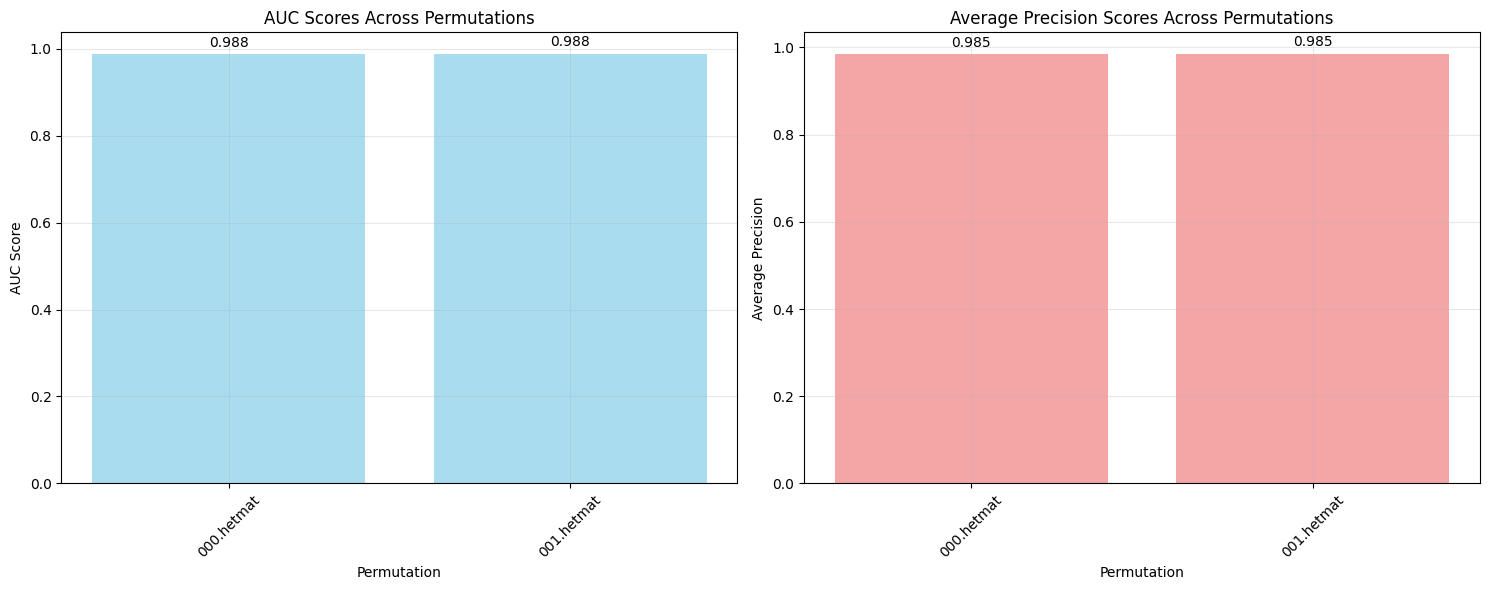


Summary Statistics:
Mean AUC: 0.9878 ± 0.0003
Mean AP: 0.9851 ± 0.0003
Min AUC: 0.9875, Max AUC: 0.9880
Min AP: 0.9849, Max AP: 0.9854
NEURAL NETWORK SETUP COMPLETE!
✓ Data loading functions defined
✓ Neural network architecture implemented
✓ Training pipeline established
✓ Evaluation and visualization tools ready
✓ Single permutation model trained

To train across all permutations, uncomment the lines above.
The model predicts edge probability based on source and target node degrees.


In [17]:
# Optional: Train across all permutations (uncomment to run)
# This will take longer as it trains a separate model for each permutation

all_results = train_across_permutations(all_perm_data, epochs=20)
plot_permutation_comparison(all_results)

print("="*60)
print("NEURAL NETWORK SETUP COMPLETE!")
print("="*60)
print("✓ Data loading functions defined")
print("✓ Neural network architecture implemented")
print("✓ Training pipeline established")
print("✓ Evaluation and visualization tools ready")
print("✓ Single permutation model trained")
print("\nTo train across all permutations, uncomment the lines above.")
print("The model predicts edge probability based on source and target node degrees.")

In [ ]:
def create_average_edge_probability_heatmap(all_results, degree_ranges=None, resolution=100):
    """
    Create a heatmap showing average edge probability across all permutations 
    based on source and target degrees.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results from all permutations
    degree_ranges : tuple or None
        (min_degree, max_degree) for both source and target. If None, uses data ranges
    resolution : int
        Number of grid points along each axis
    
    Returns:
    --------
    tuple : (avg_probability_matrix, std_probability_matrix, source_degrees, target_degrees)
    """
    
    # Get degree ranges from the first successful permutation if not provided
    if degree_ranges is None:
        # Find first successful permutation to get degree ranges
        first_perm = None
        for perm_name, result in all_results.items():
            if result is not None:
                first_perm = perm_name
                break
        
        if first_perm is None:
            raise ValueError("No successful permutation results found")
        
        # Get degree ranges from the first permutation data
        perm_data = all_perm_data[first_perm]
        anatomy_degrees = np.array(perm_data['aeg_edges'].sum(axis=1)).flatten()
        gene_degrees = np.array(perm_data['aeg_edges'].sum(axis=0)).flatten()
        
        min_source = max(1, anatomy_degrees.min())
        max_source = anatomy_degrees.max()
        min_target = max(1, gene_degrees.min())
        max_target = gene_degrees.max()
    else:
        min_source, max_source = degree_ranges
        min_target, max_target = degree_ranges
    
    print(f"Computing average heatmap with degree ranges:")
    print(f"Source degree range: {min_source} - {max_source}")
    print(f"Target degree range: {min_target} - {max_target}")
    print(f"Resolution: {resolution}x{resolution}")
    
    # Create degree grids
    source_degrees = np.linspace(min_source, max_source, resolution)
    target_degrees = np.linspace(min_target, max_target, resolution)
    
    # Create meshgrid for all combinations
    source_grid, target_grid = np.meshgrid(source_degrees, target_degrees)
    
    # Flatten grids to create feature matrix
    features_grid = np.column_stack([
        source_grid.flatten(),
        target_grid.flatten()
    ])
    
    # Collect probability matrices from all successful permutations
    probability_matrices = []
    successful_perms = []
    
    for perm_name, result in all_results.items():
        if result is not None:
            try:
                model = result['model']
                scaler = result['test_metrics']['scaler']
                
                # Scale features using this permutation's scaler
                features_scaled = scaler.transform(features_grid)
                
                # Convert to PyTorch tensor
                features_tensor = torch.FloatTensor(features_scaled)
                
                # Get predictions
                model.eval()
                with torch.no_grad():
                    probabilities = model(features_tensor).cpu().numpy()
                
                # Reshape back to grid
                prob_matrix = probabilities.reshape(resolution, resolution)
                probability_matrices.append(prob_matrix)
                successful_perms.append(perm_name)
                
                print(f"✓ Processed {perm_name}: prob range {prob_matrix.min():.4f}-{prob_matrix.max():.4f}")
                
            except Exception as e:
                print(f"✗ Failed to process {perm_name}: {e}")
    
    if not probability_matrices:
        raise ValueError("No probability matrices could be computed")
    
    # Convert to numpy array and compute statistics
    prob_array = np.array(probability_matrices)  # Shape: (n_permutations, resolution, resolution)
    
    # Compute mean and standard deviation across permutations
    avg_probability_matrix = np.mean(prob_array, axis=0)
    std_probability_matrix = np.std(prob_array, axis=0)
    
    print(f"\nSuccessfully processed {len(probability_matrices)} permutations: {successful_perms}")
    print(f"Average probability range: {avg_probability_matrix.min():.4f} - {avg_probability_matrix.max():.4f}")
    print(f"Average std deviation: {std_probability_matrix.mean():.4f}")
    
    return avg_probability_matrix, std_probability_matrix, source_degrees, target_degrees

# Create the average heatmap across all permutations
print("="*70)
print("CREATING AVERAGE EDGE PROBABILITY HEATMAP ACROSS ALL PERMUTATIONS")
print("="*70)

# Compute average probability heatmap
avg_prob_matrix, std_prob_matrix, source_degs, target_degs = create_average_edge_probability_heatmap(
    all_results, resolution=100
)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Average probability heatmap
im1 = axes[0, 0].imshow(avg_prob_matrix, 
                        extent=[source_degs.min(), source_degs.max(), 
                               target_degs.min(), target_degs.max()],
                        origin='lower', aspect='auto', cmap='viridis', alpha=0.9)

axes[0, 0].set_xlabel('Source Degree (Anatomy)')
axes[0, 0].set_ylabel('Target Degree (Gene)')
axes[0, 0].set_title('Average Edge Probability Heatmap\n(Across All Permutations)')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Average Edge Probability')

# Add contour lines for average probabilities
contour_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
contours1 = axes[0, 0].contour(source_degs, target_degs, avg_prob_matrix, 
                               levels=contour_levels, colors='white', alpha=0.7, linewidths=1.5)
axes[0, 0].clabel(contours1, inline=True, fontsize=8, fmt='%.2f')

# 2. Standard deviation heatmap
im2 = axes[0, 1].imshow(std_prob_matrix, 
                        extent=[source_degs.min(), source_degs.max(), 
                               target_degs.min(), target_degs.max()],
                        origin='lower', aspect='auto', cmap='Reds', alpha=0.9)

axes[0, 1].set_xlabel('Source Degree (Anatomy)')
axes[0, 1].set_ylabel('Target Degree (Gene)')
axes[0, 1].set_title('Standard Deviation of Edge Probability\n(Across All Permutations)')

cbar2 = plt.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('Standard Deviation')

# 3. Coefficient of variation (std/mean) heatmap
cv_matrix = std_prob_matrix / (avg_prob_matrix + 1e-8)  # Add small epsilon to avoid division by zero
im3 = axes[1, 0].imshow(cv_matrix, 
                        extent=[source_degs.min(), source_degs.max(), 
                               target_degs.min(), target_degs.max()],
                        origin='lower', aspect='auto', cmap='plasma', alpha=0.9)

axes[1, 0].set_xlabel('Source Degree (Anatomy)')
axes[1, 0].set_ylabel('Target Degree (Gene)')
axes[1, 0].set_title('Coefficient of Variation\n(Std Dev / Mean)')

cbar3 = plt.colorbar(im3, ax=axes[1, 0])
cbar3.set_label('Coefficient of Variation')

# 4. Average probability vs source and target degree (1D views)
# Average over target degrees for source degree analysis
avg_by_source = avg_prob_matrix.mean(axis=0)
std_by_source = std_prob_matrix.mean(axis=0)

# Average over source degrees for target degree analysis
avg_by_target = avg_prob_matrix.mean(axis=1)
std_by_target = std_prob_matrix.mean(axis=1)

axes[1, 1].plot(source_degs, avg_by_source, 'b-', linewidth=2, label='Avg by Source Degree')
axes[1, 1].fill_between(source_degs, 
                       avg_by_source - std_by_source, 
                       avg_by_source + std_by_source, 
                       alpha=0.3, color='blue')

ax_twin = axes[1, 1].twinx()
ax_twin.plot(target_degs, avg_by_target, 'r-', linewidth=2, label='Avg by Target Degree')
ax_twin.fill_between(target_degs, 
                    avg_by_target - std_by_target, 
                    avg_by_target + std_by_target, 
                    alpha=0.3, color='red')

axes[1, 1].set_xlabel('Degree')
axes[1, 1].set_ylabel('Average Probability (Source)', color='blue')
ax_twin.set_ylabel('Average Probability (Target)', color='red')
axes[1, 1].set_title('Average Probability vs Degree')

# Add legends
axes[1, 1].legend(loc='upper left')
ax_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"Average probability across all permutations: {avg_prob_matrix.mean():.4f} ± {avg_prob_matrix.std():.4f}")
print(f"Average standard deviation across permutations: {std_prob_matrix.mean():.4f}")
print(f"Average coefficient of variation: {cv_matrix.mean():.4f}")
print(f"Probability range: {avg_prob_matrix.min():.4f} - {avg_prob_matrix.max():.4f}")

# Find regions with highest and lowest variability
high_var_threshold = np.percentile(std_prob_matrix, 90)
low_var_threshold = np.percentile(std_prob_matrix, 10)

print(f"\nHigh variability regions (>90th percentile, std > {high_var_threshold:.4f}):")
high_var_indices = np.where(std_prob_matrix > high_var_threshold)
if len(high_var_indices[0]) > 0:
    for i in range(min(3, len(high_var_indices[0]))):
        target_idx, source_idx = high_var_indices[0][i], high_var_indices[1][i]
        avg_val = avg_prob_matrix[target_idx, source_idx]
        std_val = std_prob_matrix[target_idx, source_idx]
        print(f"  Source: {source_degs[source_idx]:.1f}, Target: {target_degs[target_idx]:.1f}, "
              f"Avg: {avg_val:.4f}, Std: {std_val:.4f}")

print(f"\nLow variability regions (<10th percentile, std < {low_var_threshold:.4f}):")
low_var_indices = np.where(std_prob_matrix < low_var_threshold)
if len(low_var_indices[0]) > 0:
    for i in range(min(3, len(low_var_indices[0]))):
        target_idx, source_idx = low_var_indices[0][i], low_var_indices[1][i]
        avg_val = avg_prob_matrix[target_idx, source_idx]
        std_val = std_prob_matrix[target_idx, source_idx]
        print(f"  Source: {source_degs[source_idx]:.1f}, Target: {target_degs[target_idx]:.1f}, "
              f"Avg: {avg_val:.4f}, Std: {std_val:.4f}")